In [14]:
import os
import sys
sys.path.append('../examples')
sys.path.append('../jobs')
sys.path.append('../training_data')

from tqdm import trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config

import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

# 1. Probability mass captured by the top 128 tokens

In [3]:
def set_seed(seed=42, n_gpu=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()

set_seed()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
model.eval()

vocab_size = tokenizer.vocab_size

In [15]:
file = '../training_data/gbw/training/news.en-00001-of-00100'

probs = []
with open(file) as fp:
    for line in fp:
        context = tokenizer.encode(line)
        context = torch.tensor(context, dtype=torch.long, device=device).unsqueeze(0)
        inputs = {'input_ids': context}
        outputs = model(**inputs)  # Note: we could also use 'past' with GPT-2/Transfo-XL/XLNet (cached hidden-states)
        model_next_logits = outputs[0][:, -1, :]
        next_probs = F.softmax(model_next_logits, dim=-1)[0].detach().cpu().numpy()
        sorted_probs = np.sort(next_probs)[::-1]
        probs.append(sorted_probs[:128].sum())

RuntimeError: The size of tensor a (2154) must match the size of tensor b (1024) at non-singleton dimension 3

(array([4.0000e+01, 1.3600e+02, 3.8900e+02, 9.0800e+02, 1.8990e+03,
        5.2760e+03, 2.4660e+04, 8.8879e+04, 6.5651e+04, 1.3163e+04]),
 array([0.26060456, 0.33454236, 0.4084802 , 0.482418  , 0.55635583,
        0.6302936 , 0.70423144, 0.7781693 , 0.8521071 , 0.9260449 ,
        0.9999827 ], dtype=float32),
 <a list of 10 Patch objects>)

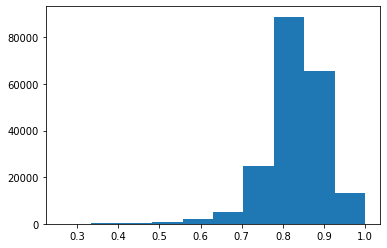

In [16]:
plt.hist(probs)

In [26]:
probs = np.array(probs)
greater = np.ones(len(probs))
greater[probs < 0.7] = 0
pct = greater.sum() / len(probs)

In [27]:
pct

0.7395585096591559

In [28]:
len(probs)

201001

In [30]:
np.savez('top128_prob_mass', p=probs)